<a href="https://colab.research.google.com/github/gokmenkilic/ML-Intro/blob/gk%2Ftests/astronomy_denoising_power_density_spectrums_solution_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Denoising power density spectrum using convolutional autoencoders.

In this notebook, we attempt to remove noise in power density spectrum of Kepler red giant using convolutional autoencoders.

[The Kepler mission](https://www.science.org/doi/10.1126/science.1185402) was designed to determine the frequency of Earth-sized planets in and near the habitable zone of Sun-like stars. Some of the most fundamental studies are to identify which stars show oscillations and to locate the frequency at maximum power. However, these studies are suffer from noise in signals.

The aim of this work is to use a very deep convolutional autoencoder to remove noise in power density spectrum of Kepler red giant.



In [ ]:
# tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# check version
print('Using TensorFlow v%s' % tf.__version__)
acc_str = 'accuracy' if tf.__version__[:2] == '2.' else 'acc'

# helpers
import urllib.request
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import h5py
import pickle
from sklearn.model_selection import train_test_split
from os.path import join

# need some certainty in data processing
np.random.seed(1234)
tf.random.set_seed(1234)

Using TensorFlow v2.19.0


## Data Setup & Google Colab Environment

The dataset is hosted publicly by DiRAC on COSMA.  **Please make sure you run the cell below to download the data.**

To access the data from COSMA, you need to:

1. Run the first cell;
2. It will create a folder called `sciml-workshop-data`.
3. It will download the necessary HDF5 files directly into that folder.
4. Run the second cell and wait until the data folder appears.

If everything works correctly, a new folder called `sciml-workshop-data` should appear in the file browser on the left. Depending on the network speed, this may take one or two minutes. Ignore the warning "You do not appear to have access to project ...". If you are running the notebook locally or you have already connected to the bucket, these cells will have no side effects.

In [ ]:
# data setup configuration
data_path = 'sciml-workshop-data'
full_dir = os.path.join(data_path, 'Astronomy')
os.makedirs(full_dir, exist_ok=True)

base_url = "https://virgodb.cosma.dur.ac.uk/public/dc-kili1/sciml-workshop-data/Astronomy/"
files_to_download = ["kepler.pickle"]

In [ ]:
for filename in files_to_download:
    path = os.path.join(full_dir, filename)

    if not os.path.exists(path):
        urllib.request.urlretrieve(base_url + filename, path)

---

# 1. Load the dataset

### Read raw data

The data is stored in 'Astronomy/kepler.pickle', containing 6175 power density spectrum of Kepler red giant. The data has been preprocessed a bit using logarithm and median of each sample - so the values are between 0 and 2.

**Suggested Answer**

<details> <summary>Show / Hide</summary>
<p>
    
```python
data_path = join(data_path,'Astronomy/kepler.pickle')
with open(data_path, 'rb') as f:
    x_train = pickle.load(f)[0][:, :2**15]
```
    
</p>
</details>

In [ ]:
data_path = join(data_path,'Astronomy/kepler.pickle')
with open(data_path, 'rb') as f:
    x_train = pickle.load(f)[0][:, :2**15]

In [ ]:
x_train = np.expand_dims(x_train, -1)
print(x_train.shape)

(6175, 32768, 1)


Text(0.5, 0.95, 'Examples')

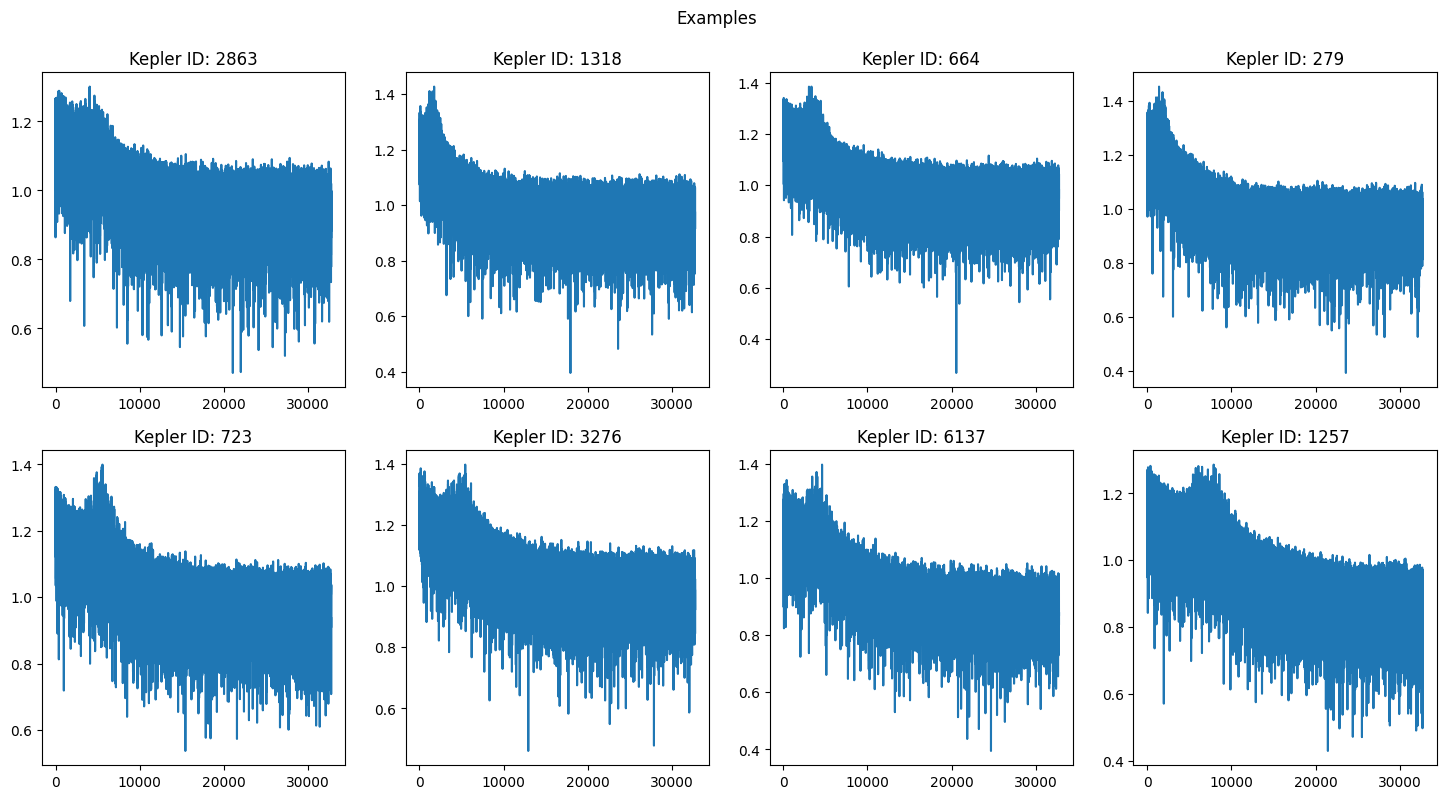

In [ ]:
idxs = np.random.choice(len(x_train), 8)

fig, ax = plt.subplots(2, 4, figsize = (18, 9))
for j in range(2):
    for i in range(4):
        ax[j, i].plot(x_train[idxs[i*2+j]].reshape(-1))
        ax[j, i].set_title('Kepler ID: {}'.format(idxs[i*2+j]))

fig.suptitle('Examples', y = 0.95)

---

# 2. Build the network

The task is to build and train a convolutional autoencoder to remove noise in signals. The signals are 1D array, hence, we use 1D convolution in an encoder and 1D transposed convolution in a decoder.

### The encoder

The encoder contains five 1D convolutional layers, an input layer with size 32768$\times$1 and one dense layer with size 32:

**Suggested Answer**

<details> <summary>Show / Hide</summary>
<p>
    
```python
# build the encoder
image_input = keras.Input(shape=(32768, 1))
#x = layers.Flatten()(image_input)
x = layers.Conv1D(8, 7, 4, padding = 'same')(image_input)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv1D(16, 5, 2, padding = 'same')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv1D(16, 5, 2, padding = 'same')(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv1D(32, 5, 2, padding = 'same')(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv1D(32, 5, 2, padding = 'same')(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)


x = layers.Activation('relu')(x)
x = layers.Flatten()(x)
latent_output = layers.Dense(32)(x)
encoder_AE = keras.Model(image_input, latent_output)
encoder_AE.summary()
```
    
</p>
</details>

In [ ]:
# build the encoder
image_input = keras.Input(shape=(32768, 1))
#x = layers.Flatten()(image_input)
x = layers.Conv1D(8, 7, 4, padding = 'same')(image_input)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv1D(16, 5, 2, padding = 'same')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv1D(16, 5, 2, padding = 'same')(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv1D(32, 5, 2, padding = 'same')(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv1D(32, 5, 2, padding = 'same')(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)


x = layers.Activation('relu')(x)
x = layers.Flatten()(x)
latent_output = layers.Dense(32)(x)
encoder_AE = keras.Model(image_input, latent_output)
encoder_AE.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32768, 1)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 8192, 8)        │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 8192, 8)        │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 8192, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 4096, 16)       │           656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 4096, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 2048, 16)       │         1,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 2048, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 2048, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 1024, 32)       │         2,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 1024, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 1024, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 512, 32)        │         5,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 512, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 512, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │       524,320 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 534,496 (2.04 MB)

 Trainable params: 534,288 (2.04 MB)

 Non-trainable params: 208 (832.00 B)

### The decoder

The decoder contains sixe transposed convolutional layers and one dense layer that are reciprocal to those of the encoders and one convolutional layer, outputing denoised signals with the same size as the input signals:

**Suggested Answer**

<details> <summary>Show / Hide</summary>
<p>
    
```python
# build the decoder
latent_input = keras.Input(shape=(32))
x = layers.Dense(16384)(latent_input)
x = layers.Reshape((512, 32), input_shape=(16384,))(x)
x = layers.Conv1DTranspose(32, 5, 2, padding = 'same')(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv1DTranspose(32, 5, 2, padding = 'same')(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv1DTranspose(16, 5, 2, padding = 'same')(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv1DTranspose(16, 5, 2, padding = 'same')(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv1DTranspose(8, 5, 2, padding = 'same')(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv1DTranspose(8, 5, 2, padding = 'same')(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
image_output = layers.Conv1D(1, 3, padding = 'same')(x)

decoder_AE = keras.Model(latent_input, image_output)
decoder_AE.summary()
```
    
</p>
</details>

In [ ]:
# build the decoder
latent_input = keras.Input(shape=(32,))
x = layers.Dense(16384)(latent_input)
x = layers.Reshape((512, 32), input_shape=(16384,))(x)
x = layers.Conv1DTranspose(32, 5, 2, padding = 'same')(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv1DTranspose(32, 5, 2, padding = 'same')(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv1DTranspose(16, 5, 2, padding = 'same')(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv1DTranspose(16, 5, 2, padding = 'same')(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv1DTranspose(8, 5, 2, padding = 'same')(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv1DTranspose(8, 5, 2, padding = 'same')(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
image_output = layers.Conv1D(1, 3, padding = 'same')(x)

decoder_AE = keras.Model(latent_input, image_output)
decoder_AE.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16384)          │       540,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 512, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose                │ (None, 1024, 32)       │         5,152 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 1024, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 1024, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_1              │ (None, 2048, 32)       │         5,152 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 2048, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 2048, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_2              │ (None, 4096, 16)       │         2,576 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 4096, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 4096, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_3              │ (None, 8192, 16)       │         1,296 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 8192, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 8192, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_4              │ (None, 16384, 8)       │           648 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 16384, 8)       │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 16384, 8)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_5              │ (None, 32768, 8)       │           328 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 556,297 (2.12 MB)

 Trainable params: 556,073 (2.12 MB)

 Non-trainable params: 224 (896.00 B)

### The autoencoder

Joining up the encoder and the decoder, we obtain the AE network:

**Suggested Answer**

<details> <summary>Show / Hide</summary>
<p>
    
```python
# build the AE
image_input = keras.Input(shape=(32768, 1))
latent = encoder_AE(image_input)
image_output = decoder_AE(latent)
ae_model = keras.Model(image_input, image_output)
ae_model.summary()

# compile the AE
ae_model.compile(optimizer='adam', loss='mse', metrics=['mse'])
```
    
</p>
</details>

In [ ]:
# build the AE
image_input = keras.Input(shape=(32768, 1))
latent = encoder_AE(image_input)
image_output = decoder_AE(latent)
ae_model = keras.Model(image_input, image_output)
ae_model.summary()

# compile the AE
ae_model.compile(optimizer='adam', loss='mse', metrics=['mse'])

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 32768, 1)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional (Functional)         │ (None, 32)             │       534,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_1 (Functional)       │ (None, 32768, 1)       │       556,297 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,090,793 (4.16 MB)

 Trainable params: 1,090,361 (4.16 MB)

 Non-trainable params: 432 (1.69 KB)

In [ ]:
# train the AE
ae_model.fit(x_train, x_train, epochs=50, batch_size=64)


Epoch 1/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 30s 129ms/step - loss: 0.6027 - mse: 0.6027
Epoch 2/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - loss: 0.0158 - mse: 0.0158
Epoch 3/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - loss: 0.0092 - mse: 0.0092
Epoch 4/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - loss: 0.0074 - mse: 0.0074
Epoch 5/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - loss: 0.0065 - mse: 0.0065
Epoch 6/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - loss: 0.0060 - mse: 0.0060
Epoch 7/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - loss: 0.0056 - mse: 0.0056
Epoch 8/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - loss: 0.0054 - mse: 0.0054
Epoch 9/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - loss: 0.0052 - mse: 0.0052
Epoch 10/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - loss: 0.0052 - mse: 0.0052
Epoch 11/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - loss: 0.0051 - mse: 0.0051
Epoch 12/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - loss: 0.0050 - mse: 0.0050
Epoch 13/50
97/97 ━━━━━━━━━━━━━━━━━

---

# 3. Analyse results

### Visualize the original signals and denoised signals by AE

**Suggested Answer**

<details> <summary>Show / Hide</summary>
<p>
    
```python
idxs = [2000, 200, 5959, 1721, 123, 4231, 911, 6127]

y = ae_model.predict(x_train[idxs])

fig, ax = plt.subplots(2, 4, figsize = (18, 9))
for j in range(2):
    for i in range(4):
        ax[j, i].plot(x_train[idxs[i*2+j]].reshape(-1), label = 'orignal signal')
        ax[j, i].plot(y[i*2+j].reshape(-1), label = 'denoised signal')
        ax[j, i].set_title('Kepler ID: {}'.format(idxs[i*2+j]))
        ax[j, i].legend(loc = 1)

fig.suptitle('examples', y = 0.95)
```
    
</p>
</details>

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Text(0.5, 0.95, 'examples')

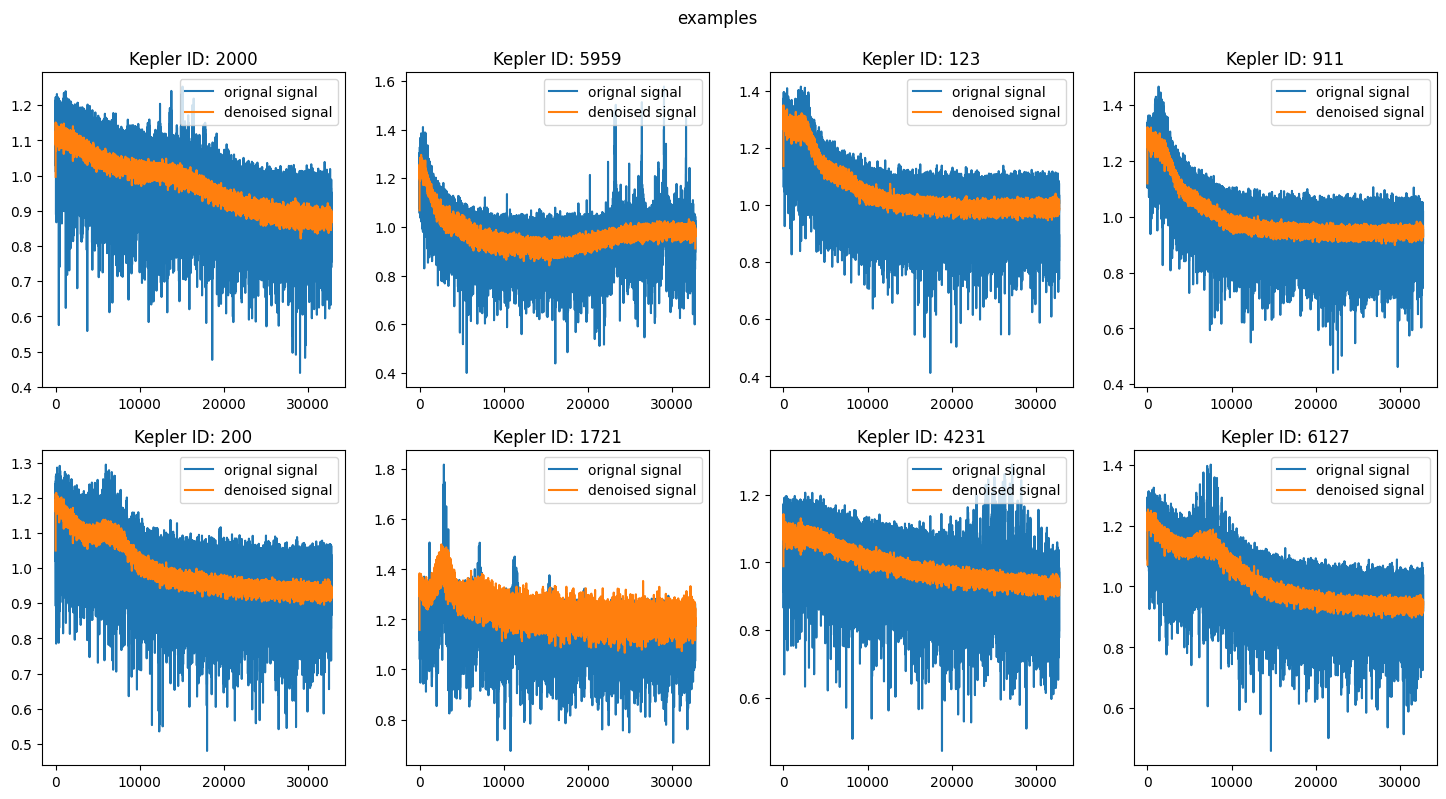

In [ ]:
idxs = [2000, 200, 5959, 1721, 123, 4231, 911, 6127]

y = ae_model.predict(x_train[idxs])

fig, ax = plt.subplots(2, 4, figsize = (18, 9))
for j in range(2):
    for i in range(4):
        ax[j, i].plot(x_train[idxs[i*2+j]].reshape(-1), label = 'orignal signal')
        ax[j, i].plot(y[i*2+j].reshape(-1), label = 'denoised signal')
        ax[j, i].set_title('Kepler ID: {}'.format(idxs[i*2+j]))
        ax[j, i].legend(loc = 1)

fig.suptitle('examples', y = 0.95)

---

# 4. Exercises

* Change some hyperparameters in `model.compile()` and `model.fit()` to see their effects (see reference of [tf.keras.Model](https://www.tensorflow.org/api_docs/python/tf/keras/Model));
* Change the architeture and activation functions of neural networks to improve the performance
* Add noise to input layer to make the network more robust to noise